## Сегментация изображений клеток

Вам предстоит обучить модель сегментировать изображения с дрожжевыми клетками и микроструктурами (см. [06_segmentation.ipynb](../workshops/06_segmentation.ipynb)), по пути поэкспериментировав с разными архитектурами и функцими ошибки.

### Задание 1 (2 балл). Метрики сегментации
Перед экспериментами нужно определиться с метриками. Выберите 3-5 метрик, по которым вы будете оценивать качество модели. В этом задании объясните свой выбор и найдите нужные метрики в `torchvision` (а если их нет - реализуйте самостоятельно, здесь вам может помочь [05_lightning_etc.ipynb](../workshops/05_lightning_etc.ipynb))

In [ ]:
from pathlib import Path
!pip install lightning
import lightning as L
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import Tensor
from torch.utils.data import Dataset
from torchvision import transforms

In [ ]:
from torchmetrics import Recall
from torchmetrics import Precision
from torchmetrics import Accuracy
from torchmetrics import F1Score
from torchmetrics import JaccardIndex

### Задание 2 (4 балла). Обучение модели
Возьмите модель и датасеты из практики по сегментации и запустите обучение.

Указания:
- Каждую эпоху сохраняйте значения ошибки и выбранные в задании 1 метрики как для обучающего датасета (`train`), так и для валидационного (`val`).
- Каждую эпоху сохраняйте примеры работы модели на 8 случайных изображениях из валидационного датасета (одной картинкой, как в практике).
- После окончания обучения выведите графики значений ваших метрик и примеры предсказаний (достаточно 4-5 изображений: для первой эпохи, 2-3 в середине обучения и ндля последней эпохи).
- Можете использовать `lightning` (вместо `lightning.pytorch.loggers.TensorBoardLogger` можно использовать `lightning.pytorch.loggers.CSVLogger`, а сохранение изображений можете реализовать как `lightning.pytorch.Callback`), а можете всё написать вручную.

In [ ]:
! wget https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
! unzip yeast_cell_in_microstructures_dataset.zip -d yeast_cell_in_microstructures_dataset

--2024-10-20 19:16:37--  https://tudatalib.ulb.tu-darmstadt.de/bitstream/handle/tudatalib/3799/yeast_cell_in_microstructures_dataset.zip
Resolving tudatalib.ulb.tu-darmstadt.de (tudatalib.ulb.tu-darmstadt.de)... 130.83.152.157
Connecting to tudatalib.ulb.tu-darmstadt.de (tudatalib.ulb.tu-darmstadt.de)|130.83.152.157|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: unspecified [application/zip]
Saving to: ‘yeast_cell_in_microstructures_dataset.zip.5’

yeast_cell_in_micro     [   <=>              ]  92.04M  12.8MB/s    in 8.1s    

Last-modified header invalid -- time-stamp ignored.
2024-10-20 19:16:46 (11.4 MB/s) - ‘yeast_cell_in_microstructures_dataset.zip.5’ saved [96507334]

Archive:  yeast_cell_in_microstructures_dataset.zip
replace yeast_cell_in_microstructures_dataset/test/bounding_boxes/395.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset_dir = Path("yeast_cell_in_microstructures_dataset")
train_dir = dataset_dir / "train"
fname = "5.pt"

for subdir in train_dir.glob("*"):
    print(f"{subdir.stem} shape: ", torch.load(subdir / fname, weights_only=True).shape)

inputs shape:  torch.Size([256, 256])
classes shape:  torch.Size([2])
bounding_boxes shape:  torch.Size([2, 4])
instances shape:  torch.Size([2, 256, 256])


In [ ]:
def masks_to_rgb(masks: Tensor) -> Tensor:
    """
    Преобразует тензор с бинарными масками произвольного кол-ва объектов (до 9)
    в тензор с тремя каналами, который можно конвертировать в RGB изображение

    Args:
        masks (Tensor): тензор с бинарными масками N отдельных объектов размера N x W x H
    """
    _colors = torch.tensor([
        [1.0, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 1.0],
        [0.5, 0.0, 0.5],
        [0.5, 0.5, 0.0],
        [0.0, 0.5, 0.5],
        [0.5, 0.3, 0.2],
        [0.2, 0.3, 0.5],
        [0.2, 0.5, 0.3],
    ])[:len(masks)]
    return (masks.unsqueeze(0) * _colors.T.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)

In [ ]:
class YeastDataset(Dataset):
    def __init__(self, subset_dir: Path) -> None:
        super().__init__()
        self.subset_dir = subset_dir
        self.items = list((self.subset_dir / "inputs").glob("*.pt"))

    def __getitem__(self, index: int) -> tuple[Tensor, dict[str, Tensor]]:
        # нужно вернуть пару
        # тензор изображения C x W x H
        # словарь с ключами boxes, masks, labels
        image_path = self.items[index]
        image = torch.load(image_path, weights_only=True).unsqueeze(
            0
        )  # (W, H) -> (1, W, H)
        classes = (
            torch.load(
                self.subset_dir / "classes" / image_path.parts[-1], weights_only=True
            )
            + 1
        )  # 0 класс - фон
        masks = torch.load(
            self.subset_dir / "instances" / image_path.parts[-1], weights_only=True
        )
        boxes = torch.load(
            self.subset_dir / "bounding_boxes" / image_path.parts[-1], weights_only=True
        )
        return image, dict(
            boxes=boxes,
            labels=classes,
            masks=masks,
        )

    def __len__(self) -> int:
        return len(self.items)

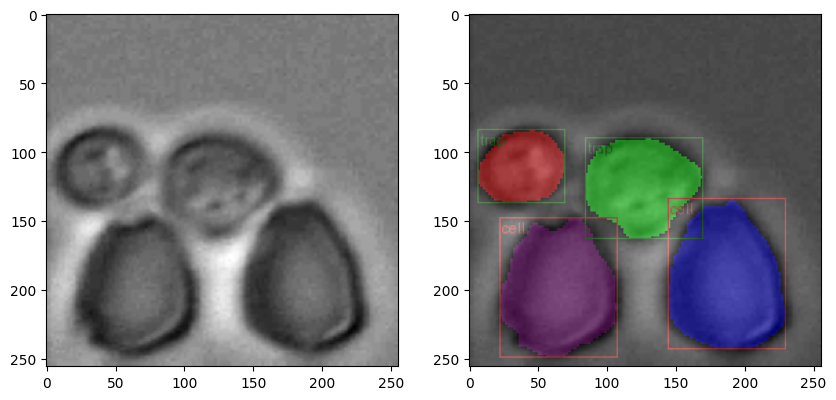

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

train_dataset = YeastDataset(train_dir)

x, target = train_dataset[5]
ax[0].imshow(x[0], cmap="gray")
ax[1].imshow(x[0], cmap="gray")


colordict = {1: "red", 2: "green"}
class_names = {1: "cell", 2: "trap"}

annot = torchvision.utils.draw_bounding_boxes(
    transforms.ConvertImageDtype(torch.uint8)(masks_to_rgb(target["masks"])),
    boxes=target["boxes"],
    colors=[colordict[i.item()] for i in target["labels"]],
    labels=[class_names[i.item()] for i in target["labels"]],
)
ax[1].imshow(transforms.ToPILImage()(annot), alpha=0.4)

In [ ]:
class YeastSemanticSegmDataset(YeastDataset):
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor]:
        image, annotation = super().__getitem__(index)
        # нужно сформировать маску: тензор размера W x H, где для каждого пиксела указан класс
        mask = (
            (annotation["masks"] * annotation["labels"].view(-1, 1, 1)).sum(dim=0)
        ).long()

        return image, mask

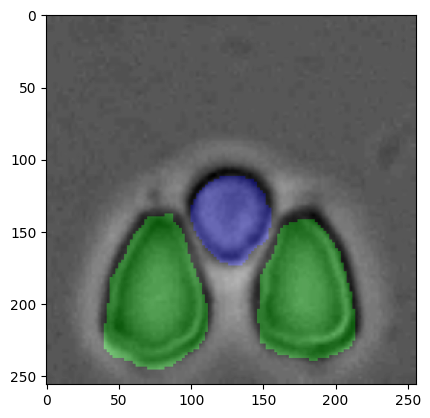

In [ ]:
train_dataset = YeastSemanticSegmDataset(train_dir)

x, y = train_dataset[0]
y = torch.nn.functional.one_hot(y, 3).permute(2, 0, 1).float()
y[0] = 0.0

fig, ax = plt.subplots(1, 1)
ax.imshow(x[0], cmap="gray")
ax.imshow(transforms.ToPILImage()(y), alpha=0.3)

In [ ]:
from typing import Any, Callable, Type

from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS
from torch.utils.data import DataLoader

_collate_fn_t = Callable[[list[tuple[Tensor, Any]]], Any]


class Datamodule(L.LightningDataModule):
    def __init__(
        self,
        datadir: Path,
        dataset_class: Type[Dataset],
        batch_size: int,
        train_subdir: str = "train",
        val_subdir: str = "val",
        test_subdir: str = "test",
    ) -> None:
        super().__init__()
        self.batch_size = batch_size
        self.dataset_class = dataset_class
        self.train_dir = datadir / train_subdir
        self.val_dir = datadir / val_subdir
        self.test_dir = datadir / test_subdir

    @property
    def collate_fn(self) -> _collate_fn_t | None:
        if self.dataset_class == YeastSemanticSegmDataset:
            return None
        else:
            return lambda batch: tuple(zip(*batch))

    def setup(self, stage: str) -> None:
        if stage in ("fit", "validate"):
            self.val_dataset = self.dataset_class(self.val_dir)
        if stage == "fit":
            self.train_dataset = self.dataset_class(self.train_dir)
        elif stage == "test":
            self.test_dataset = self.dataset_class(self.test_dir)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
        )

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
        )

In [ ]:
torch.manual_seed(42)
datamodule = Datamodule(
    datadir=Path("yeast_cell_in_microstructures_dataset"),
    dataset_class=YeastSemanticSegmDataset,
    batch_size=8,
)
datamodule.setup("fit")
images, masks = next(iter(datamodule.train_dataloader()))
print(images.shape)
print(masks.shape)

torch.Size([8, 1, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(
        self, in_channels: int, out_channels: int, mid_channels: int | None = None
    ) -> None:
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(
        self, in_channels: int, out_channels: int, bilinear: bool = True
    ) -> None:
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(
                in_channels, in_channels // 2, kernel_size=2, stride=2
            )
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x_prev: Tensor, x_skip: Tensor) -> Tensor:
        x_prev = self.up(x_prev)
        # input is BCHW
        d_height = x_skip.size()[2] - x_prev.size()[2]
        d_width = x_skip.size()[3] - x_prev.size()[3]

        x_prev = F.pad(
            x_prev,
            [
                d_width // 2,
                d_width - d_width // 2,
                d_height // 2,
                d_height - d_height // 2,
            ],
        )
        x = torch.cat([x_skip, x_prev], dim=1)
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(
        self,
        n_channels: int,
        n_classes: int,
        channel_sizes: list[int],
        bilinear: bool = False,
    ):
        super().__init__()
        self.in_conv = DoubleConv(in_channels=n_channels, out_channels=channel_sizes[0])
        self.downscaler = self.create_downscaler(channel_sizes, bilinear)
        self.upscaler = self.create_upscaler(channel_sizes[::-1], bilinear)
        self.head = nn.Conv2d(channel_sizes[0], n_classes, kernel_size=1)

    @classmethod
    def create_downscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        если используется билинейная интерполяция вместо обратной свёртки,
        то размер последнего (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        down_factors = [1] * (len(channel_sizes) - 2) + [factor]
        return nn.ModuleList(
            [
                Down(fin, fout // dfactor)
                for fin, fout, dfactor in zip(
                    channel_sizes[:-1], channel_sizes[1:], down_factors
                )
            ]
        )

    @classmethod
    def create_upscaler(
        cls, channel_sizes: list[int], bilinear: bool = False
    ) -> nn.ModuleList:
        """
        Создаём список модулей на основе размеров каналов.
        Если используется билинейная интерполяция вместо обратной свёртки,
        то размер первого (самого большого) канала делаем вдвое меньше

        Args:
            channel_sizes (list[int]): список размеров каналов, напр. [16, 32, 64]
            bilinear (bool, optional): если True, в модели используется билинейная интерполяция
                для выравнивания размеров активаций.
        """
        factor = 2 if bilinear else 1
        up_factors = [factor] * (len(channel_sizes) - 2) + [1]
        return nn.ModuleList(
            [
                Up(fin, fout // ufactor, bilinear=bilinear)
                for fin, fout, ufactor in list(
                    zip(channel_sizes[:-1], channel_sizes[1:], up_factors)
                )
            ]
        )

    def forward(self, x: Tensor) -> Tensor:
        # создаём список для хранения промежуточных активаций
        xs = []
        # делаем входную свёртку
        x = self.in_conv(x)

        # downscaling
        for conv in self.downscaler:
            xs.append(x)
            x = conv(x)

        # разворачиваем промежуточные активации и делаем upscaling
        xs.reverse()
        for conv, act in zip(self.upscaler, xs):
            x = conv(x, act)

        # финальная свёртка для получения логитов пикселей
        logits = self.head(x)
        return logits

In [ ]:
torch.manual_seed(42)
model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True)
sum([p.numel() for p in model.parameters()])

268515

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
from typing import cast

from lightning.pytorch.callbacks import Callback
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torchmetrics.classification.confusion_matrix import ConfusionMatrix


In [ ]:
import torchmetrics.classification

import copy

def create_classification_metrics(
    num_classes: int, prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            Recall(task="multiclass", num_classes=num_classes, average="macro"),
            Precision(task="multiclass", num_classes=num_classes, average="macro"),
            Accuracy(task="multiclass", num_classes=num_classes, average="macro"),
            F1Score(task="multiclass", num_classes=num_classes, average="macro"),
            JaccardIndex(task="multiclass", num_classes=num_classes, average="macro"),
        ],
        prefix=prefix,
    )

def print_image(predictions, images):
  original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
  masks_grid = torchvision.utils.make_grid(
      torch.nn.functional.one_hot(predictions.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
      > 0,
      nrow=4,
  )

  predictions_grid = torchvision.utils.draw_segmentation_masks(
      original_images_grid,
      masks=masks_grid,
      alpha=0.4,
      colors=["red", "green"],
  )

  plt.figure(figsize=(12, 5))
  plt.axis("off")
  plt.imshow(transforms.ToPILImage()(predictions_grid))

metrics = []

class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate
        self.train_metrics = create_classification_metrics(num_classes=3, prefix="train_")
        self.val_metrics = create_classification_metrics(num_classes=3, prefix="val_")
        self.predictions = None
        self.images = None

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        x, y = batch
        y_hat = self.model(x)
        self.predictions = y_hat
        self.images = x
        loss = F.cross_entropy(y_hat, y)
        # loss теперь сохраняем только раз в эпоху
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.train_metrics.update(y_hat, y)
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)

        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model(x)
        self.predictions = y_hat
        self.images = x
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.val_metrics.update(y_hat, y)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)
        # на этот раз вернём предсказания - будем их потом использовать, чтобы отрисовывать confusion matrix

        return {
            "loss": loss,
            "preds": y_hat,
        }

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # давайте кроме оптимизатора создадим ещё расписание для шага оптимизации
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[5, 10, 15]
            ),
        }

    def on_validation_epoch_end(self) -> None:
        metrics.append(copy.deepcopy(self.trainer.callback_metrics))
        [print(key, value.item()) for key, value in self.trainer.callback_metrics.items()]
        print_image(self.predictions, self.images)
        print('=========================================================================')
        self.val_metrics.reset()


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss 1.1126127243041992
val_MulticlassRecall 0.3333333432674408
val_MulticlassPrecision 0.05197397992014885
val_MulticlassAccuracy 0.3333333432674408
val_MulticlassF1Score 0.08992645144462585
val_MulticlassJaccardIndex 0.05197397992014885


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (37) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.4406895637512207
val_MulticlassRecall 0.7709612846374512
val_MulticlassPrecision 0.871055006980896
val_MulticlassAccuracy 0.7709612846374512
val_MulticlassF1Score 0.8109259605407715
val_MulticlassJaccardIndex 0.7031880021095276


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.32683444023132324
val_MulticlassRecall 0.8436192274093628
val_MulticlassPrecision 0.8779618740081787
val_MulticlassAccuracy 0.8436192274093628
val_MulticlassF1Score 0.8502097129821777
val_MulticlassJaccardIndex 0.7539482116699219
train_loss 0.544514536857605
train_MulticlassRecall 0.6444966793060303
train_MulticlassPrecision 0.7633756399154663
train_MulticlassAccuracy 0.6444966793060303
train_MulticlassF1Score 0.5891583561897278
train_MulticlassJaccardIndex 0.48693788051605225


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.2319244146347046
val_MulticlassRecall 0.9434047937393188
val_MulticlassPrecision 0.8865077495574951
val_MulticlassAccuracy 0.9434047937393188
val_MulticlassF1Score 0.9119055271148682
val_MulticlassJaccardIndex 0.8431296348571777
train_loss 0.33632582426071167
train_MulticlassRecall 0.8783463835716248
train_MulticlassPrecision 0.8933248519897461
train_MulticlassAccuracy 0.8783463835716248
train_MulticlassF1Score 0.8828127384185791
train_MulticlassJaccardIndex 0.7996299266815186


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.17316247522830963
val_MulticlassRecall 0.9069205522537231
val_MulticlassPrecision 0.9415432214736938
val_MulticlassAccuracy 0.9069205522537231
val_MulticlassF1Score 0.9226679801940918
val_MulticlassJaccardIndex 0.8612754344940186
train_loss 0.23287123441696167
train_MulticlassRecall 0.919704020023346
train_MulticlassPrecision 0.9218893051147461
train_MulticlassAccuracy 0.919704020023346
train_MulticlassF1Score 0.9205993413925171
train_MulticlassJaccardIndex 0.8569854497909546


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.13460561633110046
val_MulticlassRecall 0.9454115629196167
val_MulticlassPrecision 0.9289103746414185
val_MulticlassAccuracy 0.9454115629196167
val_MulticlassF1Score 0.9366666078567505
val_MulticlassJaccardIndex 0.8833791017532349
train_loss 0.1751824915409088
train_MulticlassRecall 0.9297646284103394
train_MulticlassPrecision 0.9334797859191895
train_MulticlassAccuracy 0.9297646284103394
train_MulticlassF1Score 0.9315502643585205
train_MulticlassJaccardIndex 0.8746495842933655


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.12723544239997864
val_MulticlassRecall 0.9480920433998108
val_MulticlassPrecision 0.946617841720581
val_MulticlassAccuracy 0.9480920433998108
val_MulticlassF1Score 0.9473534226417542
val_MulticlassJaccardIndex 0.9015710353851318
train_loss 0.14894482493400574
train_MulticlassRecall 0.9290108680725098
train_MulticlassPrecision 0.9315261840820312
train_MulticlassAccuracy 0.9290108680725098
train_MulticlassF1Score 0.9302568435668945
train_MulticlassJaccardIndex 0.8726227879524231


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.12267027050256729
val_MulticlassRecall 0.9455006122589111
val_MulticlassPrecision 0.9493259787559509
val_MulticlassAccuracy 0.9455006122589111
val_MulticlassF1Score 0.9473559856414795
val_MulticlassJaccardIndex 0.9015871286392212
train_loss 0.12568579614162445
train_MulticlassRecall 0.9377546310424805
train_MulticlassPrecision 0.9512094855308533
train_MulticlassAccuracy 0.9377546310424805
train_MulticlassF1Score 0.9442768096923828
train_MulticlassJaccardIndex 0.8961031436920166


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.11949799209833145
val_MulticlassRecall 0.9484577178955078
val_MulticlassPrecision 0.9483907222747803
val_MulticlassAccuracy 0.9484577178955078
val_MulticlassF1Score 0.9484089016914368
val_MulticlassJaccardIndex 0.9033854007720947
train_loss 0.11847211420536041
train_MulticlassRecall 0.948628842830658
train_MulticlassPrecision 0.9501763582229614
train_MulticlassAccuracy 0.948628842830658
train_MulticlassF1Score 0.9493902921676636
train_MulticlassJaccardIndex 0.9049129486083984


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.1165938451886177
val_MulticlassRecall 0.9450849294662476
val_MulticlassPrecision 0.9542014598846436
val_MulticlassAccuracy 0.9450849294662476
val_MulticlassF1Score 0.9495720863342285
val_MulticlassJaccardIndex 0.9054185748100281
train_loss 0.11510493606328964
train_MulticlassRecall 0.9493569135665894
train_MulticlassPrecision 0.9517205953598022
train_MulticlassAccuracy 0.9493569135665894
train_MulticlassF1Score 0.9505225419998169
train_MulticlassJaccardIndex 0.9068688154220581


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


val_loss 0.11411446332931519
val_MulticlassRecall 0.9493914842605591
val_MulticlassPrecision 0.9508868455886841
val_MulticlassAccuracy 0.9493914842605591
val_MulticlassF1Score 0.9501298666000366
val_MulticlassJaccardIndex 0.9063652753829956
train_loss 0.11260960251092911
train_MulticlassRecall 0.9495944976806641
train_MulticlassPrecision 0.953525185585022
train_MulticlassAccuracy 0.9495944976806641
train_MulticlassF1Score 0.9515304565429688
train_MulticlassJaccardIndex 0.9086369276046753


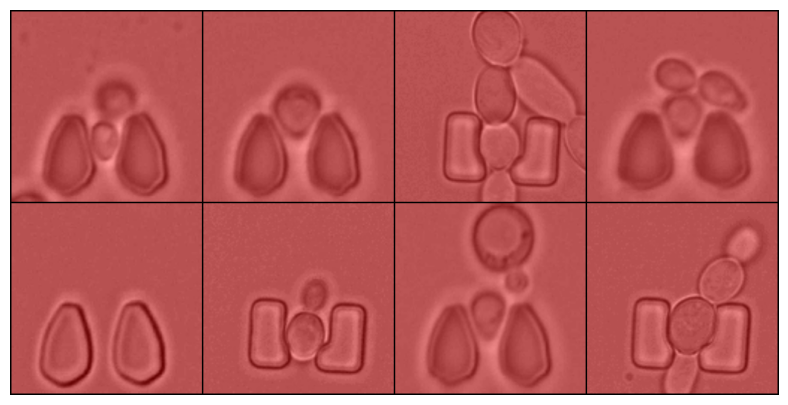

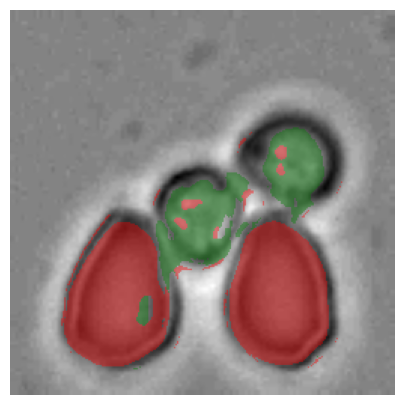

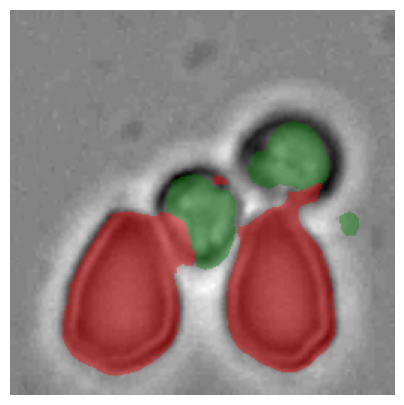

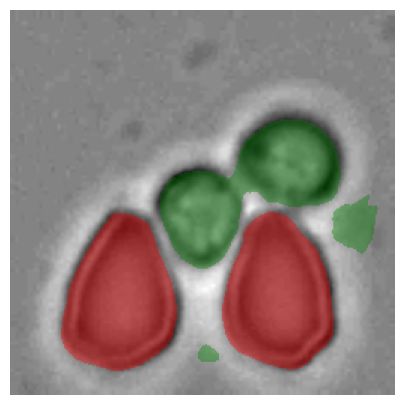

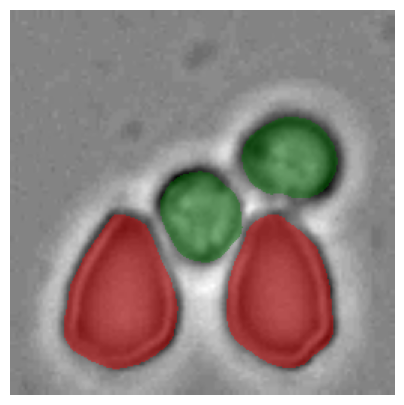

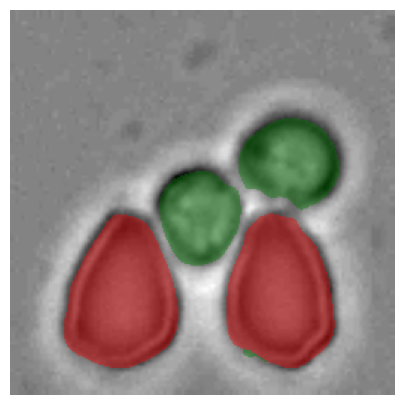

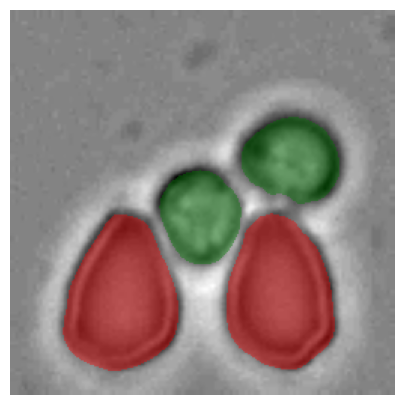

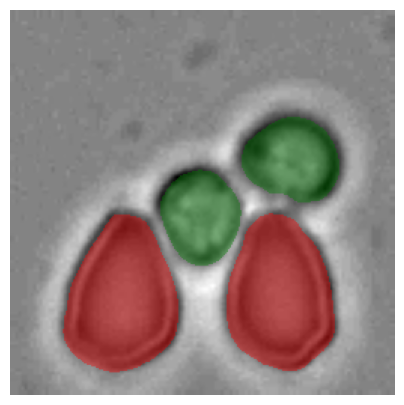

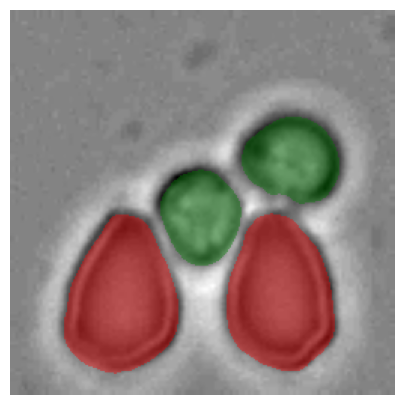

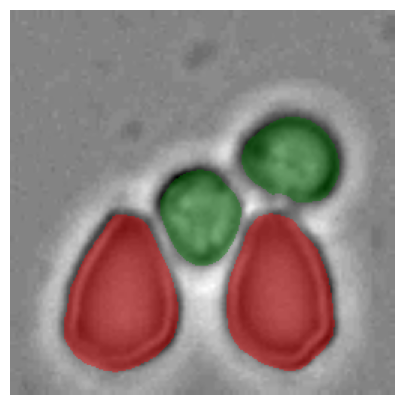

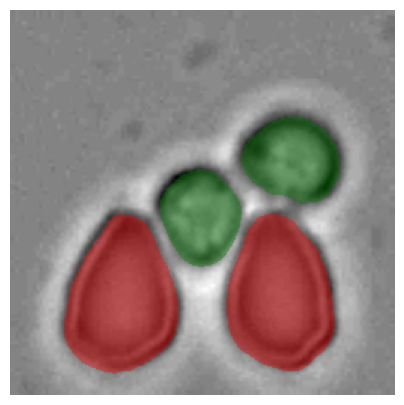

In [ ]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=None,
    limit_val_batches=None,
)
model_unet = Lit(
    model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True),
    learning_rate=1e-3,
)

trainer.fit(
    model=model_unet,
    datamodule=datamodule,
)


In [ ]:
print(metrics)

[{'val_loss': tensor(1.1457, device='cuda:0'), 'val_MulticlassRecall': tensor(0.3333, device='cuda:0'), 'val_MulticlassPrecision': tensor(0.0293, device='cuda:0'), 'val_MulticlassAccuracy': tensor(0.3333, device='cuda:0'), 'val_MulticlassF1Score': tensor(0.0539, device='cuda:0'), 'val_MulticlassJaccardIndex': tensor(0.0293, device='cuda:0')}, {'val_loss': tensor(0.1138, device='cuda:0'), 'val_MulticlassRecall': tensor(0.9482, device='cuda:0'), 'val_MulticlassPrecision': tensor(0.9526, device='cuda:0'), 'val_MulticlassAccuracy': tensor(0.9482, device='cuda:0'), 'val_MulticlassF1Score': tensor(0.9504, device='cuda:0'), 'val_MulticlassJaccardIndex': tensor(0.9068, device='cuda:0'), 'train_loss': tensor(0.1088, device='cuda:0'), 'train_MulticlassRecall': tensor(0.9550, device='cuda:0'), 'train_MulticlassPrecision': tensor(0.9539, device='cuda:0'), 'train_MulticlassAccuracy': tensor(0.9550, device='cuda:0'), 'train_MulticlassF1Score': tensor(0.9545, device='cuda:0'), 'train_MulticlassJaccar

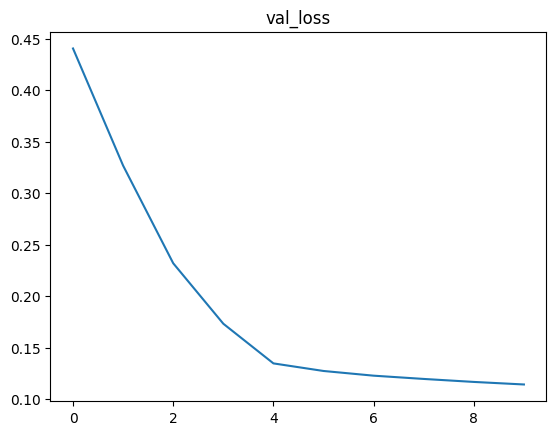

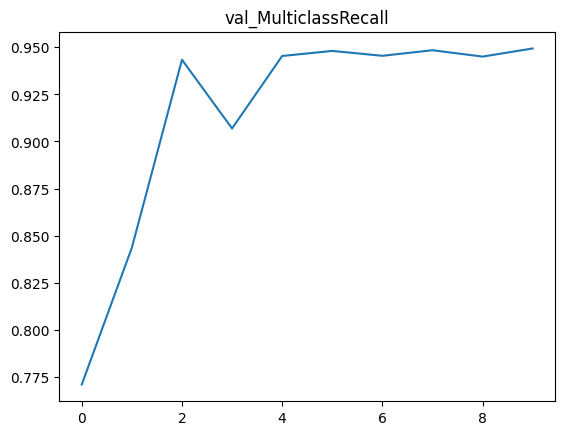

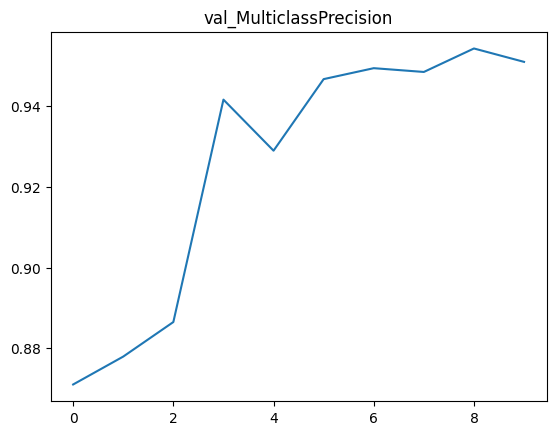

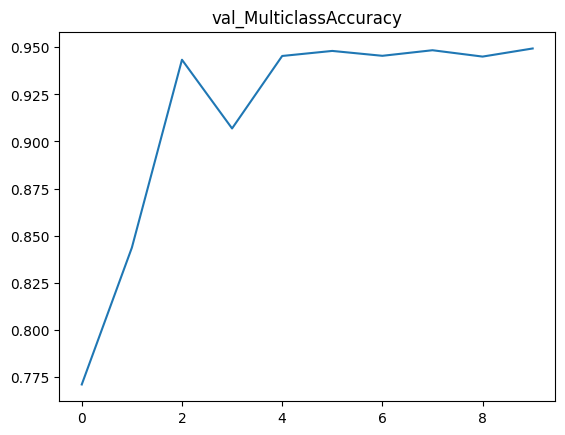

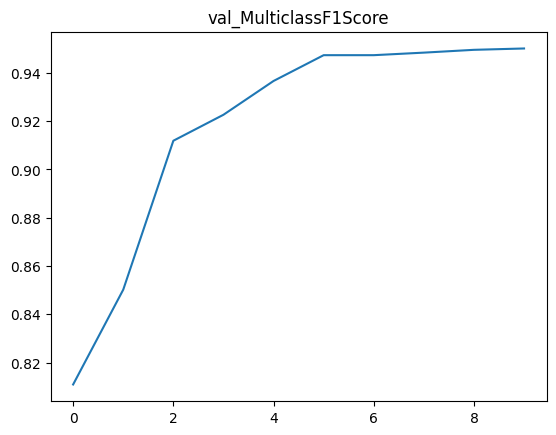

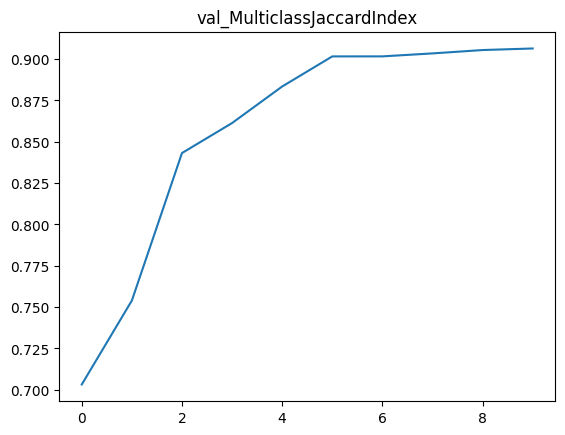

In [ ]:
import matplotlib.pyplot as plt

ln = 10
for metric in metrics[1]:
  plt.title(metric)
  plt.plot(range(ln), [y.item() for y in map(lambda t: t[metric], metrics[1:])] )
  plt.show()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.11411446332931519
val_MulticlassRecall 0.9493914842605591
val_MulticlassPrecision 0.9508868455886841
val_MulticlassAccuracy 0.9493914842605591
val_MulticlassF1Score 0.9501298666000366
val_MulticlassJaccardIndex 0.9063652753829956


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_MulticlassAccuracy   │     0.9493914842605591     │
│   val_MulticlassF1Score    │     0.9501298666000366     │
│ val_MulticlassJaccardIndex │     0.9063652753829956     │
│  val_MulticlassPrecision   │     0.9508868455886841     │
│    val_MulticlassRecall    │     0.9493914842605591     │
│          val_loss          │    0.11411446332931519     │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.11411446332931519,
  'val_MulticlassRecall': 0.9493914842605591,
  'val_MulticlassPrecision': 0.9508868455886841,
  'val_MulticlassAccuracy': 0.9493914842605591,
  'val_MulticlassF1Score': 0.9501298666000366,
  'val_MulticlassJaccardIndex': 0.9063652753829956}]

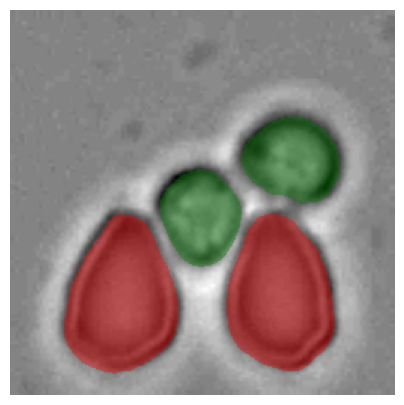

In [ ]:
trainer.validate(model=model_unet, dataloaders=datamodule.val_dataloader())

### Задание 3 (3 балла). Выбор другой функции ошибки

Полезная ссылка:
https://www.jeremyjordan.me/semantic-segmentation/#loss

Повторите эксперимент из задания 2, но попробуйте модифицировать функцию ошибки:
- (2 балла) учитывайте пиксели на границе объектов с большим весом, как предлагается в статье [U-Net](https://arxiv.org/abs/1505.04597)
- (1 балл) используйте soft Dice loss

Опишите свои наблюдения, что изменилось? Обратите внимание на скорость обучения, визуальные артефакты предсказаний, динамику метрик.


In [81]:
import numpy as np

def soft_dice_loss(y_true, y_pred, epsilon=1e-6):
    '''
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.

    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax)
        epsilon: Used for numerical stability to avoid divide by zero errors

    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)

        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''

    # skip the batch and class axis for calculating Dice score
    y_true = torch.nn.functional.one_hot(y_true.long(), num_classes=3).permute(0, 3, 1, 2)
    axes = tuple(range(1, len(y_pred.shape)-1))
    numerator = 2. * torch.sum(y_pred * y_true, axes)
    denominator = torch.sum(torch.square(y_pred) + torch.square(y_true), axes)

    return 1 - torch.mean((numerator + epsilon) / (denominator + epsilon))

In [82]:
import torchmetrics.classification

import copy

def create_classification_metrics(
    num_classes: int, prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            Recall(task="multiclass", num_classes=num_classes, average="macro"),
            Precision(task="multiclass", num_classes=num_classes, average="macro"),
            Accuracy(task="multiclass", num_classes=num_classes, average="macro"),
            F1Score(task="multiclass", num_classes=num_classes, average="macro"),
            JaccardIndex(task="multiclass", num_classes=num_classes, average="macro"),
        ],
        prefix=prefix,
    )

def print_image(predictions, images):
  original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
  masks_grid = torchvision.utils.make_grid(
      torch.nn.functional.one_hot(predictions.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
      > 0,
      nrow=4,
  )

  predictions_grid = torchvision.utils.draw_segmentation_masks(
      original_images_grid,
      masks=masks_grid,
      alpha=0.4,
      colors=["red", "green"],
  )

  plt.figure(figsize=(12, 5))
  plt.axis("off")
  plt.imshow(transforms.ToPILImage()(predictions_grid))

metrics = []

class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate
        self.train_metrics = create_classification_metrics(num_classes=3, prefix="train_")
        self.val_metrics = create_classification_metrics(num_classes=3, prefix="val_")
        self.predictions = None
        self.images = None

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        x, y = batch
        y_hat = self.model.forward(x)
        self.predictions = y_hat
        self.images = x
        loss = soft_dice_loss(y, y_hat)
        # loss теперь сохраняем только раз в эпоху
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.train_metrics.update(y_hat, y)
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)

        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model.forward(x)
        self.predictions = y_hat
        self.images = x
        loss = soft_dice_loss(y, y_hat)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.val_metrics.update(y_hat, y)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)
        # на этот раз вернём предсказания - будем их потом использовать, чтобы отрисовывать confusion matrix

        return {
            "loss": loss,
            "preds": y_hat,
        }

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # давайте кроме оптимизатора создадим ещё расписание для шага оптимизации
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[5, 10, 15]
            ),
        }

    def on_validation_epoch_end(self) -> None:
        metrics.append(copy.deepcopy(self.trainer.callback_metrics))
        [print(key, value.item()) for key, value in self.trainer.callback_metrics.items()]
        print_image(self.predictions, self.images)
        print('=========================================================================')
        self.val_metrics.reset()


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 268 K  | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
268 K     Trainable params
0         Non-trainable params
268 K     Total params
1.074     Total estimated model params size (MB)
87        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss 0.722159206867218
val_MulticlassRecall 0.3333333432674408
val_MulticlassPrecision 0.02930704690515995
val_MulticlassAccuracy 0.3333333432674408
val_MulticlassF1Score 0.05387715622782707
val_MulticlassJaccardIndex 0.02930704690515995


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.1047440841794014
val_MulticlassRecall 0.7709252834320068
val_MulticlassPrecision 0.8726316094398499
val_MulticlassAccuracy 0.7709252834320068
val_MulticlassF1Score 0.813572883605957
val_MulticlassJaccardIndex 0.7081148624420166


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.03734618425369263
val_MulticlassRecall 0.9179309606552124
val_MulticlassPrecision 0.9311277866363525
val_MulticlassAccuracy 0.9179309606552124
val_MulticlassF1Score 0.9243583679199219
val_MulticlassJaccardIndex 0.863466739654541
train_loss 0.23246005177497864
train_MulticlassRecall 0.7680782675743103
train_MulticlassPrecision 0.7232855558395386
train_MulticlassAccuracy 0.7680782675743103
train_MulticlassF1Score 0.7393512725830078
train_MulticlassJaccardIndex 0.6200732588768005


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.05499910190701485
val_MulticlassRecall 0.9111794233322144
val_MulticlassPrecision 0.8671890497207642
val_MulticlassAccuracy 0.9111794233322144
val_MulticlassF1Score 0.8861472606658936
val_MulticlassJaccardIndex 0.8029424548149109
train_loss 0.04922308400273323
train_MulticlassRecall 0.9043281078338623
train_MulticlassPrecision 0.9020720720291138
train_MulticlassAccuracy 0.9043281078338623
train_MulticlassF1Score 0.9031933546066284
train_MulticlassJaccardIndex 0.8299773931503296


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.04095437005162239
val_MulticlassRecall 0.9489809274673462
val_MulticlassPrecision 0.8868169784545898
val_MulticlassAccuracy 0.9489809274673462
val_MulticlassF1Score 0.9148794412612915
val_MulticlassJaccardIndex 0.8470244407653809
train_loss 0.033496543765068054
train_MulticlassRecall 0.9215689897537231
train_MulticlassPrecision 0.9326615333557129
train_MulticlassAccuracy 0.9215689897537231
train_MulticlassF1Score 0.9269870519638062
train_MulticlassJaccardIndex 0.8674288392066956


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.029538223519921303
val_MulticlassRecall 0.9425159692764282
val_MulticlassPrecision 0.9276199340820312
val_MulticlassAccuracy 0.9425159692764282
val_MulticlassF1Score 0.9346598386764526
val_MulticlassJaccardIndex 0.8797662258148193
train_loss 0.0278254933655262
train_MulticlassRecall 0.9347934722900391
train_MulticlassPrecision 0.9413832426071167
train_MulticlassAccuracy 0.9347934722900391
train_MulticlassF1Score 0.9380466938018799
train_MulticlassJaccardIndex 0.8854612112045288


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.023776404559612274
val_MulticlassRecall 0.9448847770690918
val_MulticlassPrecision 0.9532768726348877
val_MulticlassAccuracy 0.9448847770690918
val_MulticlassF1Score 0.9490115642547607
val_MulticlassJaccardIndex 0.90446937084198
train_loss 0.029414229094982147
train_MulticlassRecall 0.9287177324295044
train_MulticlassPrecision 0.9415758848190308
train_MulticlassAccuracy 0.9287177324295044
train_MulticlassF1Score 0.9349966049194336
train_MulticlassJaccardIndex 0.8803755044937134


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.023711424320936203
val_MulticlassRecall 0.9464819431304932
val_MulticlassPrecision 0.9522276520729065
val_MulticlassAccuracy 0.9464819431304932
val_MulticlassF1Score 0.9492917060852051
val_MulticlassJaccardIndex 0.9049392938613892
train_loss 0.023812338709831238
train_MulticlassRecall 0.9440121650695801
train_MulticlassPrecision 0.950664758682251
train_MulticlassAccuracy 0.9440121650695801
train_MulticlassF1Score 0.947304368019104
train_MulticlassJaccardIndex 0.9012405872344971


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.023298798128962517
val_MulticlassRecall 0.9429844617843628
val_MulticlassPrecision 0.9569777250289917
val_MulticlassAccuracy 0.9429844617843628
val_MulticlassF1Score 0.9497920870780945
val_MulticlassJaccardIndex 0.9058699607849121
train_loss 0.022196399047970772
train_MulticlassRecall 0.9498299360275269
train_MulticlassPrecision 0.9538958668708801
train_MulticlassAccuracy 0.9498299360275269
train_MulticlassF1Score 0.9518506526947021
train_MulticlassJaccardIndex 0.909177303314209


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.023198161274194717
val_MulticlassRecall 0.9442077875137329
val_MulticlassPrecision 0.956317663192749
val_MulticlassAccuracy 0.9442077875137329
val_MulticlassF1Score 0.9501594305038452
val_MulticlassJaccardIndex 0.9064105153083801
train_loss 0.022044794633984566
train_MulticlassRecall 0.949531078338623
train_MulticlassPrecision 0.9538841247558594
train_MulticlassAccuracy 0.949531078338623
train_MulticlassF1Score 0.9516865015029907
train_MulticlassJaccardIndex 0.9089199304580688


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


val_loss 0.022994711995124817
val_MulticlassRecall 0.9477422833442688
val_MulticlassPrecision 0.95346999168396
val_MulticlassAccuracy 0.9477422833442688
val_MulticlassF1Score 0.9505431652069092
val_MulticlassJaccardIndex 0.9071288108825684
train_loss 0.021573221310973167
train_MulticlassRecall 0.9500461220741272
train_MulticlassPrecision 0.9569638967514038
train_MulticlassAccuracy 0.9500461220741272
train_MulticlassF1Score 0.9534667730331421
train_MulticlassJaccardIndex 0.9120320081710815


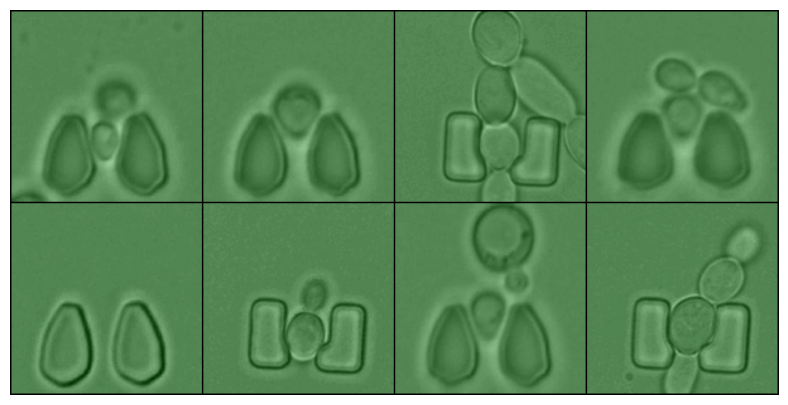

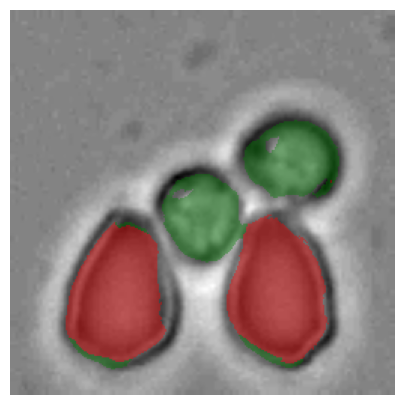

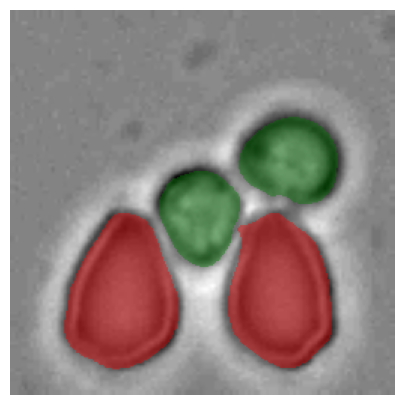

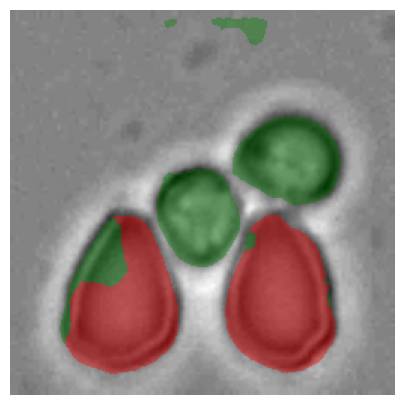

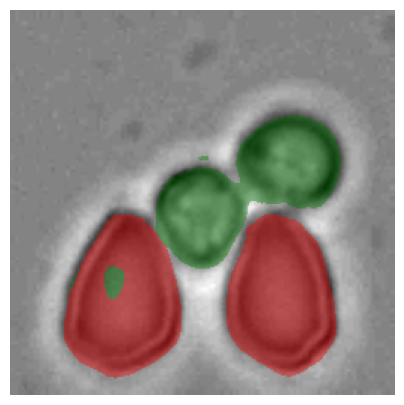

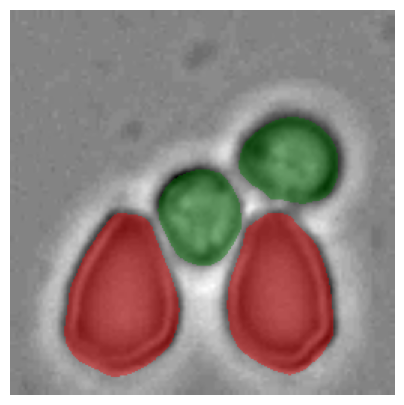

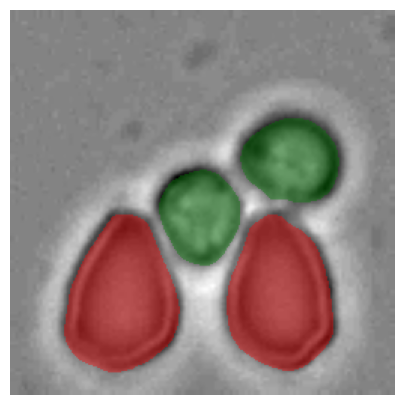

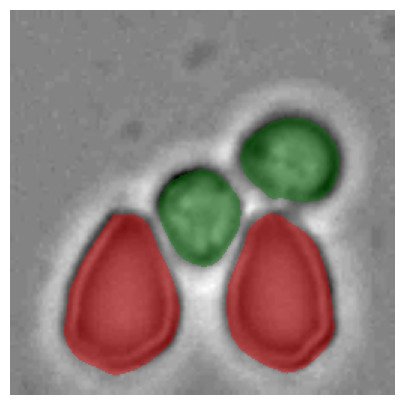

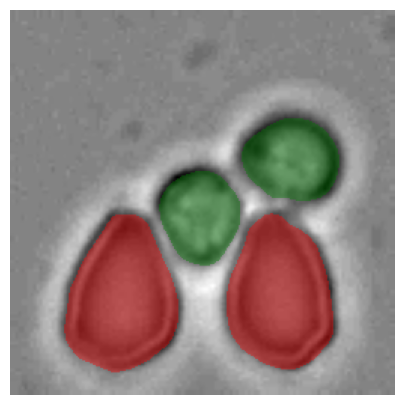

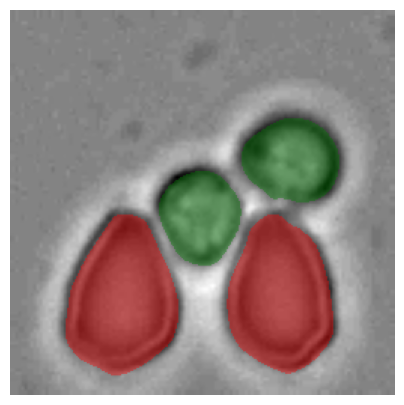

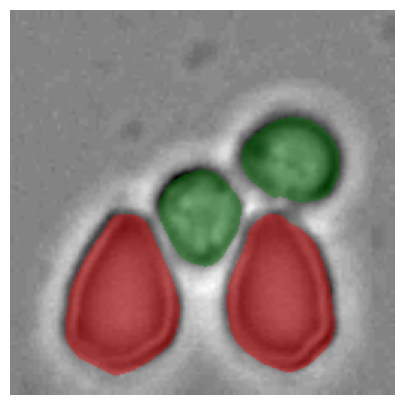

In [83]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=10,
    limit_train_batches=None,
    limit_val_batches=None,
)
model_unet = Lit(
    model = UNet(n_channels=1, n_classes=3, channel_sizes=[16, 32, 64, 128], bilinear=True),
    learning_rate=1e-3,
)

trainer.fit(
    model=model_unet,
    datamodule=datamodule,
)

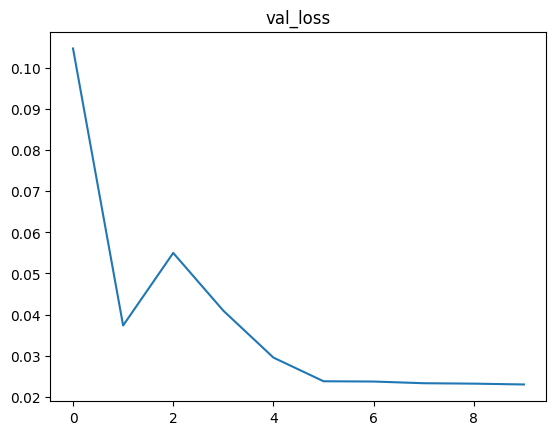

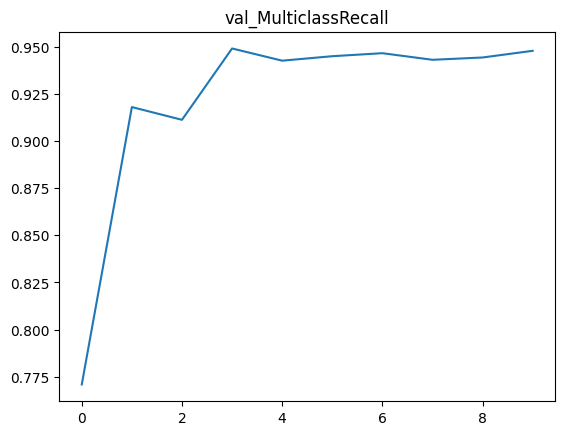

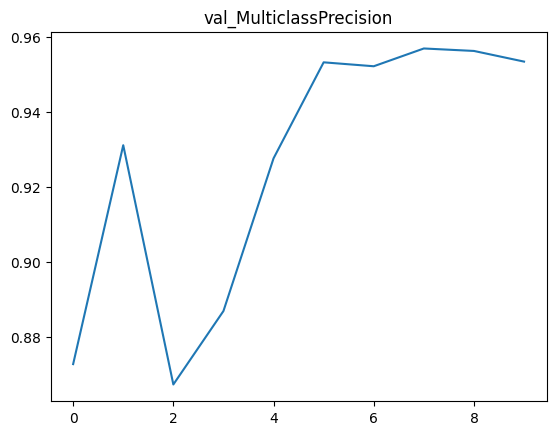

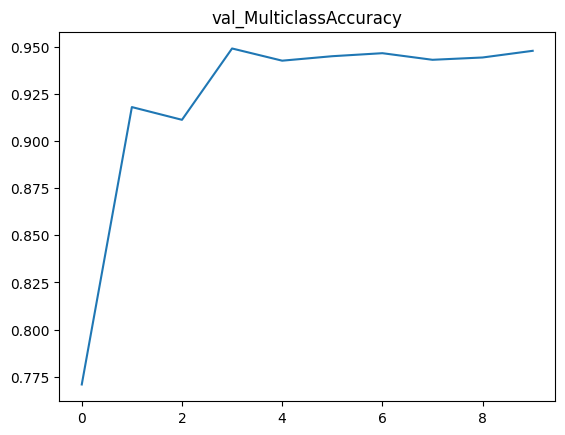

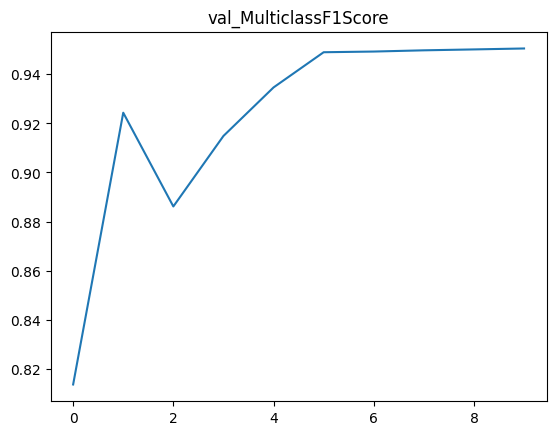

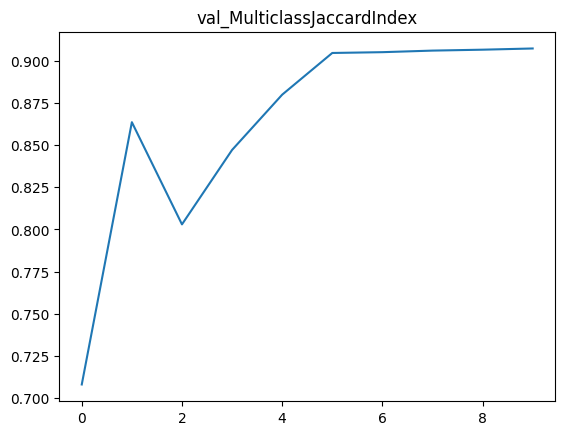

In [84]:
import matplotlib.pyplot as plt

ln = 10
for metric in metrics[1]:
  plt.title(metric)
  plt.plot(range(ln), [y.item() for y in map(lambda t: t[metric], metrics[1:])] )
  plt.show()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.022994711995124817
val_MulticlassRecall 0.9477422833442688
val_MulticlassPrecision 0.95346999168396
val_MulticlassAccuracy 0.9477422833442688
val_MulticlassF1Score 0.9505431652069092
val_MulticlassJaccardIndex 0.9071288108825684


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_MulticlassAccuracy   │     0.9477422833442688     │
│   val_MulticlassF1Score    │     0.9505431652069092     │
│ val_MulticlassJaccardIndex │     0.9071288108825684     │
│  val_MulticlassPrecision   │      0.95346999168396      │
│    val_MulticlassRecall    │     0.9477422833442688     │
│          val_loss          │    0.022994711995124817    │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.022994711995124817,
  'val_MulticlassRecall': 0.9477422833442688,
  'val_MulticlassPrecision': 0.95346999168396,
  'val_MulticlassAccuracy': 0.9477422833442688,
  'val_MulticlassF1Score': 0.9505431652069092,
  'val_MulticlassJaccardIndex': 0.9071288108825684}]

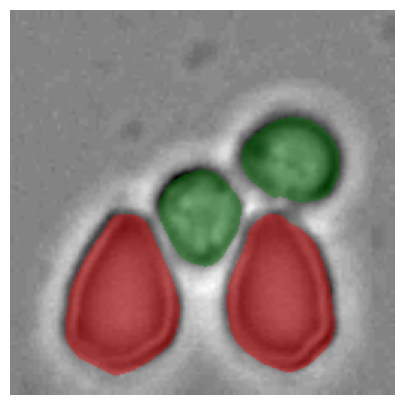

In [85]:
trainer.validate(model=model_unet, dataloaders=datamodule.val_dataloader())

In [ ]:
'''
  результаты с новой функицией в целом примерно такие же как и с дефолтной
'''

### Задание 4 (3 балла). Модификация архитектуры

Ваша задача - извлечь максимальную точность из модели, в которой будет не более 50k параметров. Для этого внесите правки в архитектуру модели.

В частности, попробуйте заменить в блоке `Down` комбинацию conv+maxpool на dilated conv (`nn.Conv2d(..., dilation=2)`). В остальном - полная свобода творчества, можете перерабатывать архитектуру как угодно.

Как обычно, запустите эксперимент (или несколько) с выводом всех графиков и картинок.

In [127]:
import scipy

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=2,
            padding=2,
            dilation=2,
            padding_mode='circular'
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.conv(x)

In [128]:
import torchmetrics.classification

import copy

def create_classification_metrics(
    num_classes: int, prefix: str
) -> torchmetrics.MetricCollection:
    return torchmetrics.MetricCollection(
        [
            Recall(task="multiclass", num_classes=num_classes, average="macro"),
            Precision(task="multiclass", num_classes=num_classes, average="macro"),
            Accuracy(task="multiclass", num_classes=num_classes, average="macro"),
            F1Score(task="multiclass", num_classes=num_classes, average="macro"),
            JaccardIndex(task="multiclass", num_classes=num_classes, average="macro"),
        ],
        prefix=prefix,
    )

def print_image(predictions, images):
  original_images_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True)
  masks_grid = torchvision.utils.make_grid(
      torch.nn.functional.one_hot(predictions.argmax(dim=1), 3).permute(0, 3, 1, 2)[:, 1:]
      > 0,
      nrow=4,
  )

  predictions_grid = torchvision.utils.draw_segmentation_masks(
      original_images_grid,
      masks=masks_grid,
      alpha=0.4,
      colors=["red", "green"],
  )

  plt.figure(figsize=(12, 5))
  plt.axis("off")
  plt.imshow(transforms.ToPILImage()(predictions_grid))

metrics = []

class Lit(L.LightningModule):
    def __init__(self, model: nn.Module, learning_rate: float) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.learning_rate = learning_rate
        self.train_metrics = create_classification_metrics(num_classes=3, prefix="train_")
        self.val_metrics = create_classification_metrics(num_classes=3, prefix="val_")
        self.predictions = None
        self.images = None

    def training_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        x, y = batch
        y_hat = self.model.forward(x)
        self.predictions = y_hat
        self.images = x
        loss = soft_dice_loss(y, y_hat)
        # loss теперь сохраняем только раз в эпоху
        self.log("train_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.train_metrics.update(y_hat, y)
        self.log_dict(self.train_metrics, on_step=False, on_epoch=True)

        return loss

    def validation_step(
        self, batch: tuple[Tensor, Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        x, y = batch
        y_hat = self.model.forward(x)
        self.predictions = y_hat
        self.images = x
        loss = soft_dice_loss(y, y_hat)
        self.log("val_loss", loss, on_epoch=True, on_step=False)
        # обновляем метрики и логируем раз в эпоху
        self.val_metrics.update(y_hat, y)
        self.log_dict(self.val_metrics, on_step=False, on_epoch=True)
        # на этот раз вернём предсказания - будем их потом использовать, чтобы отрисовывать confusion matrix

        return {
            "loss": loss,
            "preds": y_hat,
        }

    def configure_optimizers(self) -> dict[str, Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        # давайте кроме оптимизатора создадим ещё расписание для шага оптимизации
        return {
            "optimizer": optimizer,
            "lr_scheduler": torch.optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[5, 10, 15]
            ),
        }

    def on_validation_epoch_end(self) -> None:
        metrics.append(copy.deepcopy(self.trainer.callback_metrics))
        [print(key, value.item()) for key, value in self.trainer.callback_metrics.items()]
        print_image(self.predictions, self.images)
        print('=========================================================================')
        self.val_metrics.reset()


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | UNet             | 46.5 K | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
-----------------------------------------------------------
46.5 K    Trainable params
0         Non-trainable params
46.5 K    Total params
0.186     Total estimated model params size (MB)
60        Modules

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

val_loss 0.9426267147064209
val_MulticlassRecall 0.3333333432674408
val_MulticlassPrecision 0.02930704690515995
val_MulticlassAccuracy 0.3333333432674408
val_MulticlassF1Score 0.05387715622782707
val_MulticlassJaccardIndex 0.02930704690515995


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.41848909854888916
val_MulticlassRecall 0.5359159111976624
val_MulticlassPrecision 0.4482918381690979
val_MulticlassAccuracy 0.5359159111976624
val_MulticlassF1Score 0.418251097202301
val_MulticlassJaccardIndex 0.3092602491378784


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.16272422671318054
val_MulticlassRecall 0.6060442924499512
val_MulticlassPrecision 0.5013310313224792
val_MulticlassAccuracy 0.6060442924499512
val_MulticlassF1Score 0.5080408453941345
val_MulticlassJaccardIndex 0.4251590967178345
train_loss 0.5872476100921631
train_MulticlassRecall 0.43492573499679565
train_MulticlassPrecision 0.514802873134613
train_MulticlassAccuracy 0.43492573499679565
train_MulticlassF1Score 0.31605100631713867
train_MulticlassJaccardIndex 0.206708624958992


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.1017429381608963
val_MulticlassRecall 0.6849807500839233
val_MulticlassPrecision 0.7544946670532227
val_MulticlassAccuracy 0.6849807500839233
val_MulticlassF1Score 0.6682484149932861
val_MulticlassJaccardIndex 0.5684452056884766
train_loss 0.18723997473716736
train_MulticlassRecall 0.6166219711303711
train_MulticlassPrecision 0.5243136882781982
train_MulticlassAccuracy 0.6166219711303711
train_MulticlassF1Score 0.5380390882492065
train_MulticlassJaccardIndex 0.4503067433834076


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.07388181239366531
val_MulticlassRecall 0.8330566883087158
val_MulticlassPrecision 0.8353890180587769
val_MulticlassAccuracy 0.8330566883087158
val_MulticlassF1Score 0.8318748474121094
val_MulticlassJaccardIndex 0.7292157411575317
train_loss 0.08882872760295868
train_MulticlassRecall 0.6459841132164001
train_MulticlassPrecision 0.7369644045829773
train_MulticlassAccuracy 0.6459841132164001
train_MulticlassF1Score 0.6116039752960205
train_MulticlassJaccardIndex 0.5300697088241577


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.07528071105480194
val_MulticlassRecall 0.7709640860557556
val_MulticlassPrecision 0.8492828607559204
val_MulticlassAccuracy 0.7709640860557556
val_MulticlassF1Score 0.8039071559906006
val_MulticlassJaccardIndex 0.6909262537956238
train_loss 0.06531010568141937
train_MulticlassRecall 0.809989333152771
train_MulticlassPrecision 0.8521121740341187
train_MulticlassAccuracy 0.809989333152771
train_MulticlassF1Score 0.8277096748352051
train_MulticlassJaccardIndex 0.7277623414993286


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.03966941311955452
val_MulticlassRecall 0.8980586528778076
val_MulticlassPrecision 0.9179935455322266
val_MulticlassAccuracy 0.8980586528778076
val_MulticlassF1Score 0.9074796438217163
val_MulticlassJaccardIndex 0.8368250727653503
train_loss 0.04831317812204361
train_MulticlassRecall 0.8638476133346558
train_MulticlassPrecision 0.8885616064071655
train_MulticlassAccuracy 0.8638476133346558
train_MulticlassF1Score 0.8752917051315308
train_MulticlassJaccardIndex 0.7891490459442139


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.03769703581929207
val_MulticlassRecall 0.9087566137313843
val_MulticlassPrecision 0.9174745678901672
val_MulticlassAccuracy 0.9087566137313843
val_MulticlassF1Score 0.913018524646759
val_MulticlassJaccardIndex 0.8452377319335938
train_loss 0.03969471901655197
train_MulticlassRecall 0.8930362462997437
train_MulticlassPrecision 0.9155356884002686
train_MulticlassAccuracy 0.8930362462997437
train_MulticlassF1Score 0.90374755859375
train_MulticlassJaccardIndex 0.8308076858520508


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.03706692159175873
val_MulticlassRecall 0.9092460870742798
val_MulticlassPrecision 0.9201221466064453
val_MulticlassAccuracy 0.9092460870742798
val_MulticlassF1Score 0.914421558380127
val_MulticlassJaccardIndex 0.8475309610366821
train_loss 0.03665757179260254
train_MulticlassRecall 0.902592658996582
train_MulticlassPrecision 0.9223834276199341
train_MulticlassAccuracy 0.902592658996582
train_MulticlassF1Score 0.9120168089866638
train_MulticlassJaccardIndex 0.8436601161956787


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.036403704434633255
val_MulticlassRecall 0.9064226150512695
val_MulticlassPrecision 0.9261361360549927
val_MulticlassAccuracy 0.9064226150512695
val_MulticlassF1Score 0.915888786315918
val_MulticlassJaccardIndex 0.8497799634933472
train_loss 0.035720665007829666
train_MulticlassRecall 0.9065172672271729
train_MulticlassPrecision 0.9239985942840576
train_MulticlassAccuracy 0.9065172672271729
train_MulticlassF1Score 0.9149343967437744
train_MulticlassJaccardIndex 0.8481836318969727


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.036807265132665634
val_MulticlassRecall 0.9121499061584473
val_MulticlassPrecision 0.9168821573257446
val_MulticlassAccuracy 0.9121499061584473
val_MulticlassF1Score 0.9143447875976562
val_MulticlassJaccardIndex 0.8470371961593628
train_loss 0.034745652228593826
train_MulticlassRecall 0.9076476097106934
train_MulticlassPrecision 0.9279812574386597
train_MulticlassAccuracy 0.9076476097106934
train_MulticlassF1Score 0.9173721075057983
train_MulticlassJaccardIndex 0.852062463760376


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.03501434624195099
val_MulticlassRecall 0.9179447889328003
val_MulticlassPrecision 0.9231863021850586
val_MulticlassAccuracy 0.9179447889328003
val_MulticlassF1Score 0.9204854965209961
val_MulticlassJaccardIndex 0.8570403456687927
train_loss 0.033841706812381744
train_MulticlassRecall 0.9107726812362671
train_MulticlassPrecision 0.9288874864578247
train_MulticlassAccuracy 0.9107726812362671
train_MulticlassF1Score 0.9194852113723755
train_MulticlassJaccardIndex 0.8553727865219116


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.03512570261955261
val_MulticlassRecall 0.9101088047027588
val_MulticlassPrecision 0.9288632869720459
val_MulticlassAccuracy 0.9101088047027588
val_MulticlassF1Score 0.9189308881759644
val_MulticlassJaccardIndex 0.8546409606933594
train_loss 0.03263925388455391
train_MulticlassRecall 0.9181268215179443
train_MulticlassPrecision 0.9290815591812134
train_MulticlassAccuracy 0.9181268215179443
train_MulticlassF1Score 0.9234781265258789
train_MulticlassJaccardIndex 0.8616774082183838


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.034732311964035034
val_MulticlassRecall 0.9135411977767944
val_MulticlassPrecision 0.927892804145813
val_MulticlassAccuracy 0.9135411977767944
val_MulticlassF1Score 0.9204039573669434
val_MulticlassJaccardIndex 0.8569824695587158
train_loss 0.03267836943268776
train_MulticlassRecall 0.9153956770896912
train_MulticlassPrecision 0.9310444593429565
train_MulticlassAccuracy 0.9153956770896912
train_MulticlassF1Score 0.9229488372802734
train_MulticlassJaccardIndex 0.8609123229980469


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.03457207605242729
val_MulticlassRecall 0.9142804741859436
val_MulticlassPrecision 0.9280753135681152
val_MulticlassAccuracy 0.9142804741859436
val_MulticlassF1Score 0.9209058880805969
val_MulticlassJaccardIndex 0.8577769994735718
train_loss 0.03276606649160385
train_MulticlassRecall 0.9142550230026245
train_MulticlassPrecision 0.9335270524024963
train_MulticlassAccuracy 0.9142550230026245
train_MulticlassF1Score 0.9235212802886963
train_MulticlassJaccardIndex 0.8618243932723999


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


val_loss 0.034597162157297134
val_MulticlassRecall 0.9178961515426636
val_MulticlassPrecision 0.9247900247573853
val_MulticlassAccuracy 0.9178961515426636
val_MulticlassF1Score 0.9212241172790527
val_MulticlassJaccardIndex 0.8582166433334351
train_loss 0.03327079862356186
train_MulticlassRecall 0.9150115251541138
train_MulticlassPrecision 0.9309124946594238
train_MulticlassAccuracy 0.9150115251541138
train_MulticlassF1Score 0.9227182269096375
train_MulticlassJaccardIndex 0.8605592250823975


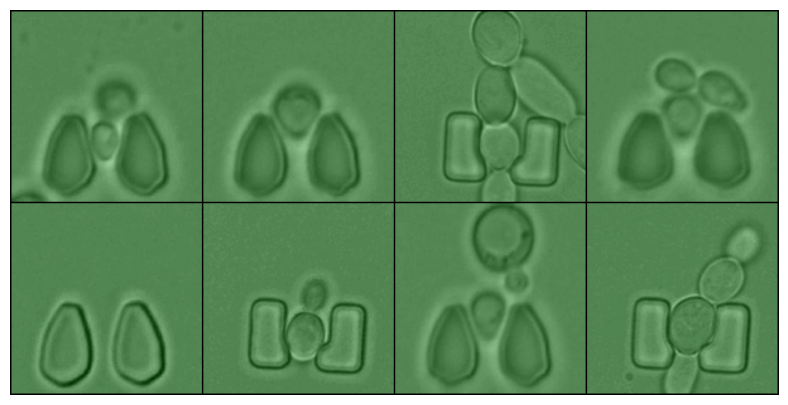

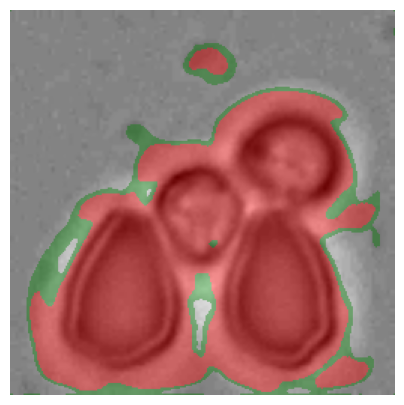

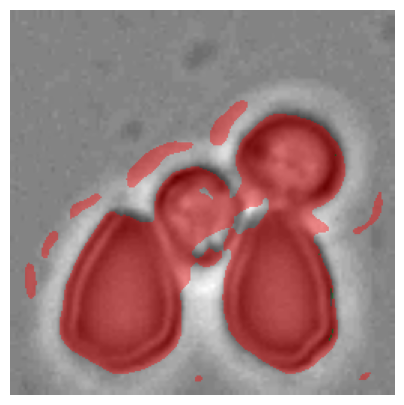

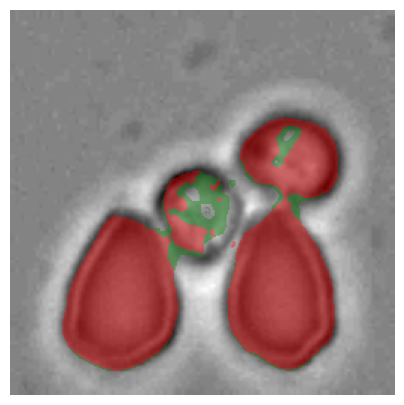

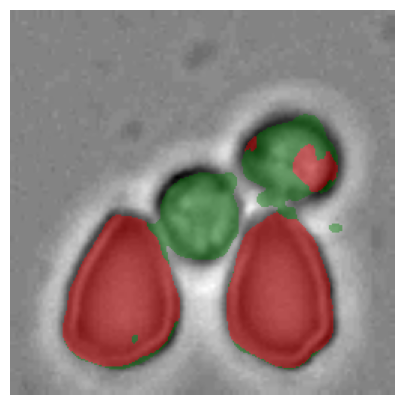

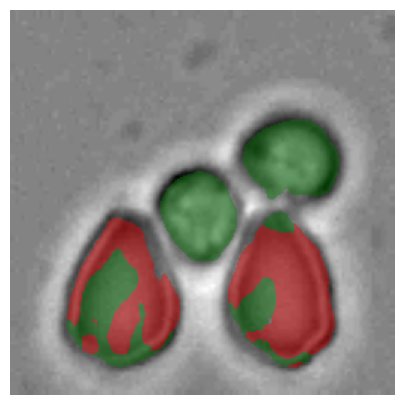

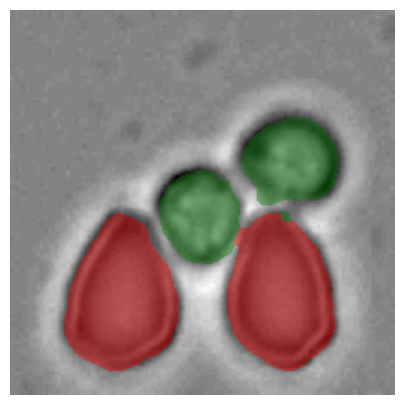

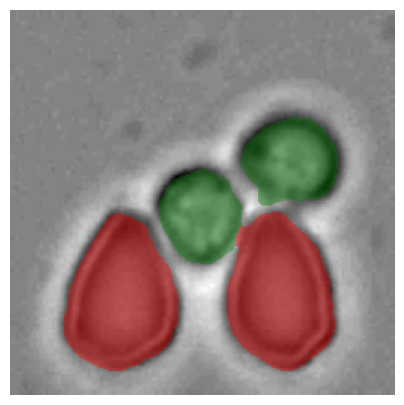

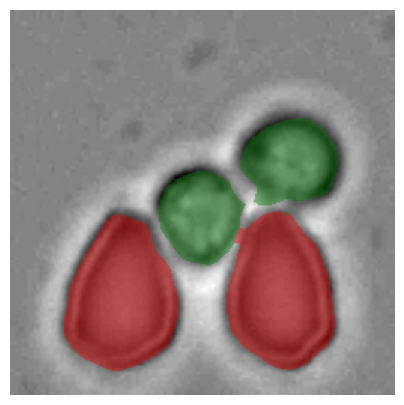

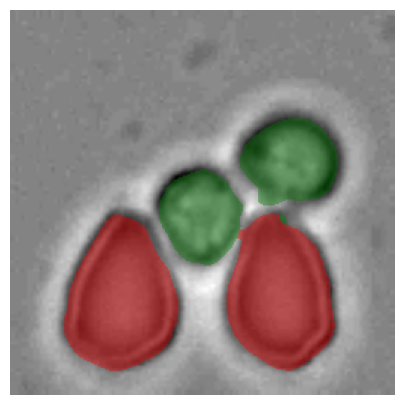

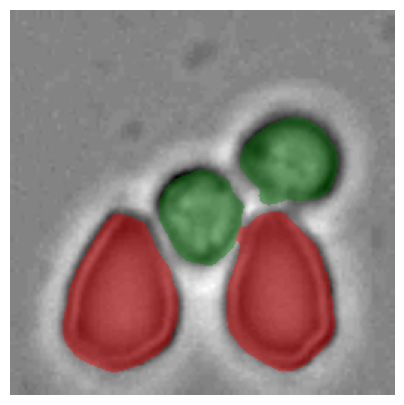

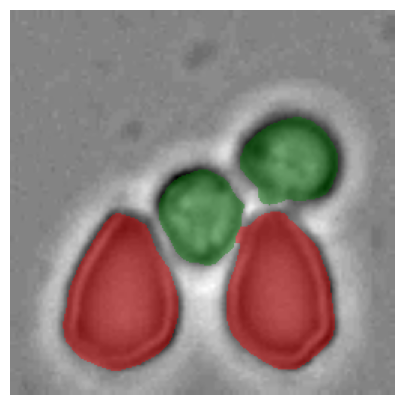

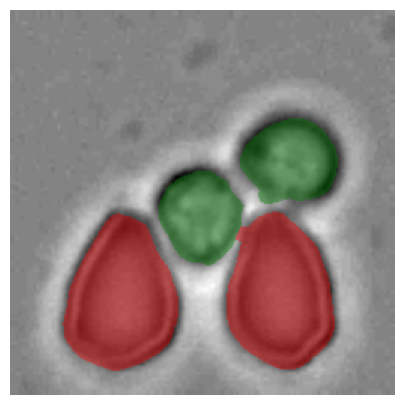

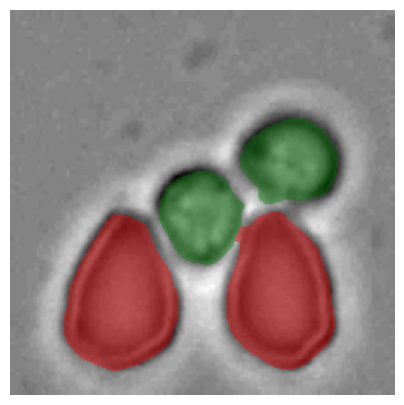

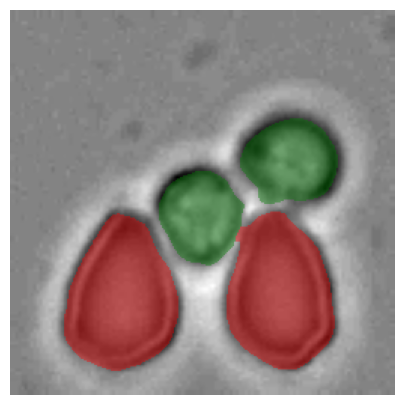

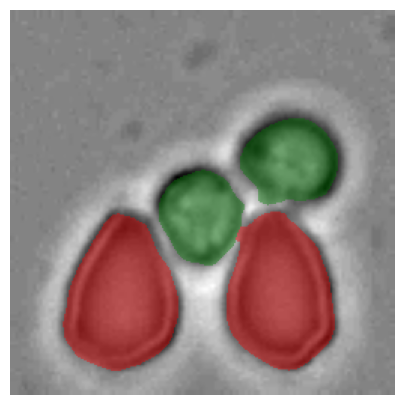

In [129]:
trainer = L.Trainer(
    accelerator="auto",
    max_epochs=15,
    limit_train_batches=None,
    limit_val_batches=None,
)
model_unet = Lit(
    model = UNet(n_channels=1, n_classes=3, channel_sizes=[8, 16, 32, 64], bilinear=True),
    learning_rate=3e-3,
)

trainer.fit(
    model=model_unet,
    datamodule=datamodule,
)

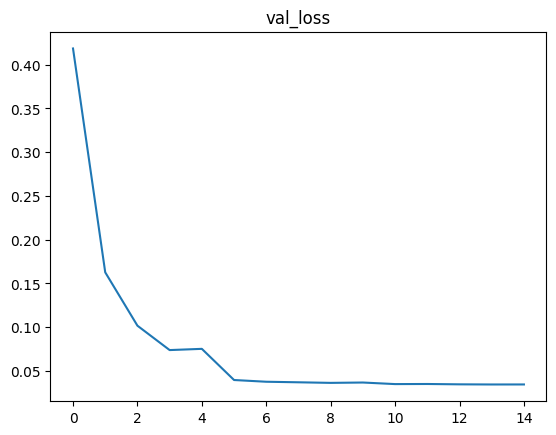

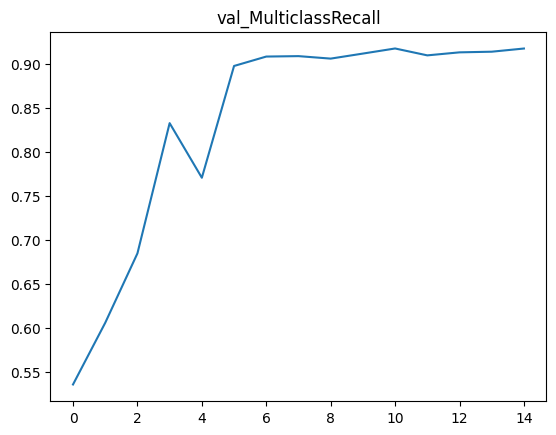

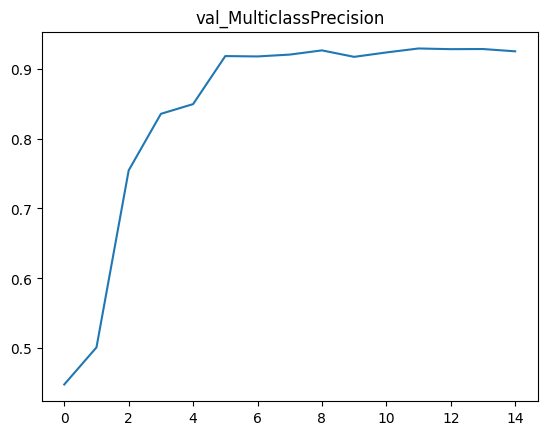

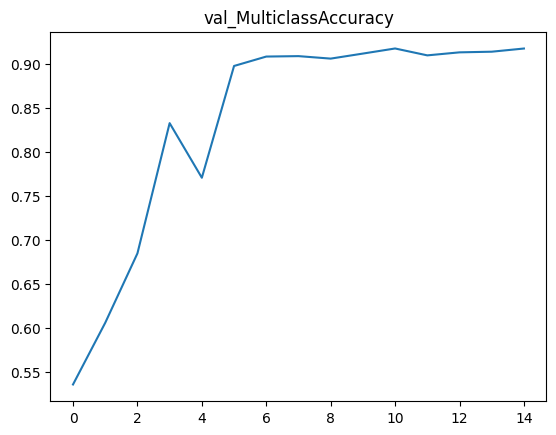

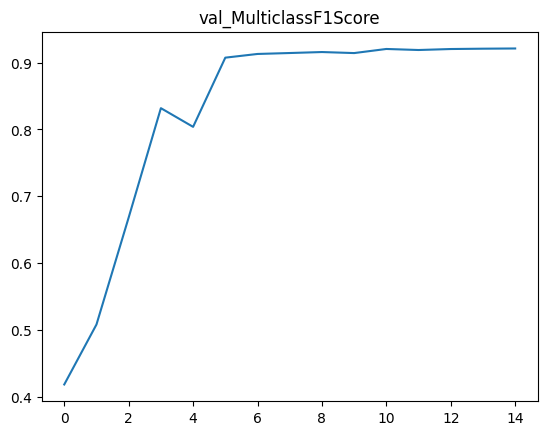

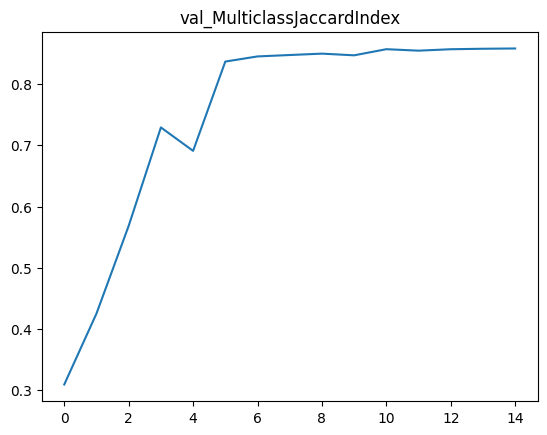

In [131]:
import matplotlib.pyplot as plt

ln = 15
for metric in metrics[1]:
  plt.title(metric)
  plt.plot(range(ln), [y.item() for y in map(lambda t: t[metric], metrics[1:])] )
  plt.show()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

val_loss 0.034597162157297134
val_MulticlassRecall 0.9178961515426636
val_MulticlassPrecision 0.9247900247573853
val_MulticlassAccuracy 0.9178961515426636
val_MulticlassF1Score 0.9212241172790527
val_MulticlassJaccardIndex 0.8582166433334351


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric       ┃        DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   val_MulticlassAccuracy   │     0.9178961515426636     │
│   val_MulticlassF1Score    │     0.9212241172790527     │
│ val_MulticlassJaccardIndex │     0.8582166433334351     │
│  val_MulticlassPrecision   │     0.9247900247573853     │
│    val_MulticlassRecall    │     0.9178961515426636     │
│          val_loss          │    0.034597162157297134    │
└────────────────────────────┴────────────────────────────┘

[{'val_loss': 0.034597162157297134,
  'val_MulticlassRecall': 0.9178961515426636,
  'val_MulticlassPrecision': 0.9247900247573853,
  'val_MulticlassAccuracy': 0.9178961515426636,
  'val_MulticlassF1Score': 0.9212241172790527,
  'val_MulticlassJaccardIndex': 0.8582166433334351}]

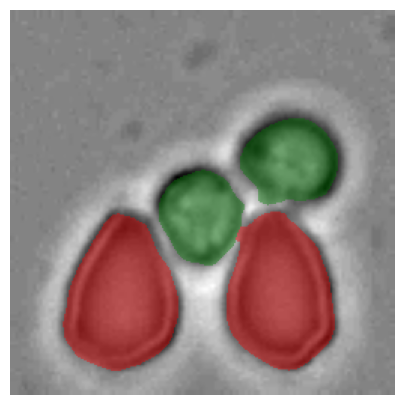

In [132]:
trainer.validate(model=model_unet, dataloaders=datamodule.val_dataloader())